In [1]:
import pytorch_ltn.ltn_models as ltn
from pytorch_ltn.optim import OptimisationTask
from pytorch_ltn.syntax import Forall, Exists, Equiv, Implies, And, Or, Not, SyntaxBackend
SyntaxBackend.UNIVERSAL_AGGREG = 'hmean'#'xentropy'#


import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
# generate artificial data

nr_of_bb = 4000

# minimal and maximal position and dimension of rectangles
min_xywh = [.0,.0,.2,.2]
max_xywh = [1.,1.,1.,1.]

# four lists of rectangles:\
# - bbs1 and bbs2 are used to generate examples R(x,y) with x in bbs1 and y in bbs2;
# - bbs12 = bbs1 + bbs2
# - bbst is the set of rectangles for test
bbs1 = np.random.uniform(min_xywh,max_xywh, size=(nr_of_bb, 4))
bbs2 = np.random.uniform(min_xywh,max_xywh, size=(nr_of_bb, 4))
bbs12 = np.concatenate([bbs1,bbs2],axis=0)
bbst = np.random.uniform([0, 0, .2, .2], [1, 1, 1, 1], size=(nr_of_bb, 4))

# funcitions that ocmputes training examples or relations between BB

def angle(bb1,bb2):
    # User center points of bbs and get angle between
    c1 = bb1[:2] + .5*bb1[2:]
    c2 = bb2[:2] + .5*bb2[2:]
    x = c2 - c1
    return np.angle(x[0] + 1j*x[1], deg=True)

def is_left(bb1,bb2):
    angle_ = angle(bb1, bb2)
    return ((angle_ > 90 ) or (angle_ < -90 ))  #bb1[0] + bb1[2] < bb2[0] and np.abs(angle(bb1, bb2)) < 5

def is_not_left(bb1,bb2):
    return not is_left(bb1, bb2)#bb1[0] + bb1[2] > bb2[0] or np.abs(angle(bb1, bb2)) > 45

def is_right(bb1, bb2):
    return is_left(bb2,bb1)

def is_not_right(bb1,bb2):
    return is_not_left(bb2,bb1)

def is_below(bb1, bb2):
    return angle(bb1,bb2) < 0. ## bb1[1] + bb1[3] < bb2[1] and np.abs(angle(bb1, bb2)-90) < 5

def is_not_below(bb1, bb2):
    return not is_below(bb1, bb2) #bb1[1] + bb1[3] > bb2[1] or np.abs(angle(bb1, bb2)-90) > 45

def is_above(bb1, bb2):
    return is_below(bb2,bb1)

def is_not_above(bb1,bb2):
    return is_not_below(bb2,bb1)

def contains(bb1,bb2):
    return bb1[0] < bb2[0] and bb1[0] + bb1[2] > bb2[0] + bb2[2] and \
           bb1[1] < bb2[1] and bb1[1] + bb1[3] > bb2[1] + bb2[3]

def not_contains(bb1,bb2):
    return not contains(bb1,bb2)

def is_in(bb1,bb2):
    return contains(bb2,bb1)

def is_not_in(bb1,bb2):
    return not is_in(bb1,bb2)

# pairs of rectangles for training

left_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if is_left(bbs1[i],bbs2[i])])
left_data = np.squeeze(left_data)

right_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if is_right(bbs1[i],bbs2[i])])
right_data = np.squeeze(right_data)

above_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if is_above(bbs1[i],bbs2[i])])
above_data = np.squeeze(above_data)

below_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if is_below(bbs1[i],bbs2[i])])
below_data = np.squeeze(below_data)

contain_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if contains(bbs1[i],bbs2[i])])
contain_data = np.squeeze(contain_data)

in_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if is_in(bbs1[i],bbs2[i])])
in_data = np.squeeze(in_data)

non_left_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if is_not_left(bbs1[i],bbs2[i])])
non_left_data = np.squeeze(non_left_data)

non_right_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if is_not_right(bbs1[i],bbs2[i])])
not_right_data = np.squeeze(non_right_data)

non_above_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if is_not_above(bbs1[i],bbs2[i])])
non_above_data = np.squeeze(non_above_data)

non_below_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if is_not_below(bbs1[i],bbs2[i])])
non_below_data = np.squeeze(non_below_data)

non_contain_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if not_contains(bbs1[i],bbs2[i])])
non_contain_data = np.squeeze(non_contain_data)

non_in_data = np.array([np.concatenate([bbs1[i],bbs2[i]],axis=0)
             for i in range(nr_of_bb)
             if is_not_in(bbs1[i],bbs2[i])])
non_in_data = np.squeeze(non_in_data)

# and of data generations


In [3]:
# start the definition of the language:

# variables for pairs of rectangles ....

# ... for positive examples of every relation
lxy = ltn.Variable("left_xy", data=left_data)
rxy = ltn.Variable("right_xy", data=right_data)
bxy = ltn.Variable("below_xy", data=below_data)
axy = ltn.Variable("above_xy", data=above_data)
cxy = ltn.Variable("contains_xy", data=contain_data)
ixy = ltn.Variable("in_xy", data=in_data)

# ... for negative examples (they are placeholders which are filled with data
# randomly generated every 100 trian epochs

nlxy = ltn.Variable("not_left_xy", num_features=8)
nrxy = ltn.Variable("not_right_xy", num_features=8)
nbxy = ltn.Variable("not_below_xy", num_features=8)
naxy = ltn.Variable("not_above_xy", num_features=8)
ncxy = ltn.Variable("not_conts_xy", num_features=8)
nixy = ltn.Variable("not_is_in_xy", num_features=8)

# printing out the cardinality of examples

pxy = [lxy, rxy, bxy, axy, cxy, ixy]
npxy = [nlxy,nrxy,nbxy,naxy,ncxy,nixy]

for xy in pxy:
    print(xy.name,xy.shape)

left_xy torch.Size([1973, 8])
right_xy torch.Size([2027, 8])
below_xy torch.Size([2006, 8])
above_xy torch.Size([1994, 8])
contains_xy torch.Size([41, 8])
in_xy torch.Size([43, 8])


In [4]:
# variables for single rectangles

x = ltn.Variable("x",4)
y = ltn.Variable("y",4)
z = ltn.Variable("z",4)

In [5]:
# relational predicates
rel_pre_params = {
    'k_depth' : 4
}

L = ltn.Predicate("left", 4, 2, pred_def='ntn', params=rel_pre_params)
R = ltn.Predicate("right" ,4, 2, pred_def='ntn', params=rel_pre_params)
B = ltn.Predicate("below", 4, 2, pred_def='ntn', params=rel_pre_params)
A = ltn.Predicate("above", 4, 2, pred_def='ntn', params=rel_pre_params)
C = ltn.Predicate("contains", 4, 2, pred_def='ntn', params=rel_pre_params)
I = ltn.Predicate("in", 4, 2, pred_def='ntn', params=rel_pre_params)

P = [L,R,B,A,C,I]

inv_P = [R,L,A,B,I,C]

In [6]:
# constraints/axioms

constraints =  [Forall(pxy[i],P[i](pxy[i]))
                for i in range(6)]
constraints += [Forall(npxy[i],Not(P[i](npxy[i])))
                for i in range(6)]
constraints += [Forall((x,y),Implies(P[i](x,y),inv_P[i](y,x)))
                for i in range(6)]
constraints += [Forall((x,y),Not(And(P[i](x,y),P[i](y,x))))
                for i in range(6)]

# constraints += [Forall((x,y,z),Implies(I(x,y),Implies(P[i](y,z),P[i](x,z)))) for i in range(6)]


In [7]:
# Prep false datasets
nr_random_bbs = 50
nlxy.filldata(non_left_data[np.random.choice(len(non_left_data),nr_random_bbs,replace=True)].astype(np.float32))
nrxy.filldata(non_right_data[np.random.choice(len(non_right_data),nr_random_bbs,replace=True)].astype(np.float32))
nbxy.filldata(non_below_data[np.random.choice(len(non_below_data),nr_random_bbs,replace=True)].astype(np.float32))
naxy.filldata(non_above_data[np.random.choice(len(non_above_data),nr_random_bbs,replace=True)].astype(np.float32))
ncxy.filldata(non_contain_data[np.random.choice(len(non_contain_data),nr_random_bbs,replace=True)].astype(np.float32))
nixy.filldata(non_in_data[np.random.choice(len(non_in_data),nr_random_bbs,replace=True)].astype(np.float32))
x.filldata(bbs12[np.random.choice(len(bbs12),nr_random_bbs,replace=True)].astype(np.float32))
y.filldata(bbs12[np.random.choice(len(bbs12),nr_random_bbs,replace=True)].astype(np.float32))
z.filldata(bbs12[np.random.choice(len(bbs12),nr_random_bbs,replace=True)].astype(np.float32))


In [8]:
optim_params = {
    'lr': 0.05,
    'weight_decay': 1e-10
}
model_parameters = []
for p in P:
    model_parameters += p.pred.parameters() #list(p.pred.parameters())

In [9]:
task = OptimisationTask(constraints, model_parameters, optim_type='adam', params=optim_params)

In [10]:
from IPython.display import clear_output
highest_score = [0, -0]
for i in range(1000):
    #import pdb; pdb.set_trace()
    sat_level = task.step(debug=True)
    score = -sat_level #1 - sat_level
    if score >= highest_score[1]:
        highest_score[0] = i
        highest_score[1] = score
    if i % 50 == 0:
        #clear_output()
        print('{} - - - - Current Score:\t{}'.format(i, score))
        print('{} - - Best Score:\t{}'.format(highest_score[0], highest_score[1]))
    #if sat_level > 0.99:
    #    break
    if score < 0.99:
        break
print('End')

Loss is  -0.574217677116394
Tensor Shape:	torch.Size([8, 4])	---	Grad sum:	-0.018292997032403946
Tensor Shape:	torch.Size([8, 8, 4])	---	Grad sum:	-0.0843278169631958
Tensor Shape:	torch.Size([4])	---	Grad sum:	-0.004002481698989868
Tensor Shape:	torch.Size([4, 1])	---	Grad sum:	0.02361718751490116
0 - - - - Current Score:	0.574217677116394
0 - - Best Score:	0.574217677116394
End


In [11]:
# TODO: Need to check what is going on in this test...
test_constraints = [Forall((x,y,z),Implies(I(x,y),
                                           Implies(P[i](y,z),P[i](x,z))))()
                    for i in range(6)]
for test_c in test_constraints:
    print(test_c)

tensor([0.9918], grad_fn=<MulBackward0>)
tensor([0.9487], grad_fn=<MulBackward0>)
tensor([0.9931], grad_fn=<MulBackward0>)
tensor([0.9319], grad_fn=<MulBackward0>)
tensor([0.9864], grad_fn=<MulBackward0>)
tensor([1.], grad_fn=<MulBackward0>)


In [12]:
# a rectangle and a set of rectangles used to show the results
ct = ltn.Constant("ct",[[.5,.5,.3,.3],]*bbst.shape[0])
t = ltn.Variable("t", data=bbst)

# ct is a centered bb and we want to check the results of predicates of scattered test (t) bbs on it
test_preds = [X(ct,t)() for X in P]

In [13]:
test_preds[0][:10]

tensor([[0.5024],
        [0.5041],
        [0.4721],
        [0.5007],
        [0.4835],
        [0.4876],
        [0.5052],
        [0.5040],
        [0.4916],
        [0.4919]], grad_fn=<SliceBackward>)

In [14]:
t.data[:10]

tensor([[0.5856, 0.3215, 0.7942, 0.3028],
        [0.2820, 0.5939, 0.8009, 0.4552],
        [0.2301, 0.4893, 0.3277, 0.6740],
        [0.5694, 0.5223, 0.5738, 0.4688],
        [0.6585, 0.0847, 0.6743, 0.7028],
        [0.8218, 0.1493, 0.8607, 0.6920],
        [0.5093, 0.2858, 0.9879, 0.3567],
        [0.1661, 0.6306, 0.5131, 0.5988],
        [0.1750, 0.5551, 0.6012, 0.9341],
        [0.4074, 0.3592, 0.6470, 0.6032]])

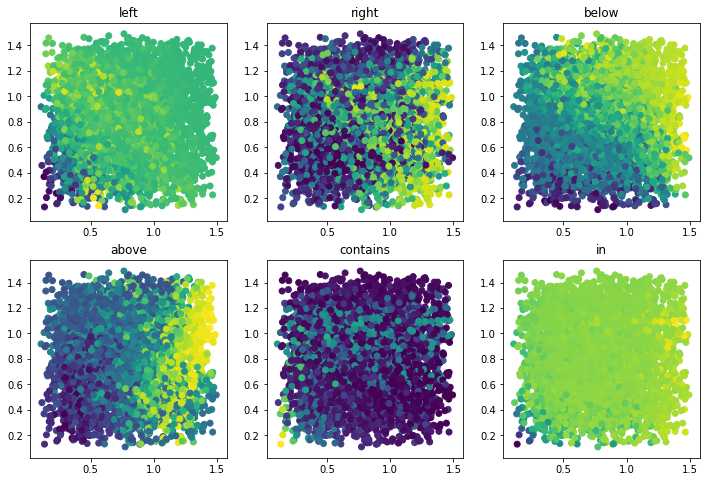

In [15]:
fig = plt.figure(figsize=(12,8))
jet = cm = plt.get_cmap('jet')
cbbst = bbst[:,:2] + 0.5*bbst[:,2:]  # seems to get the centerpoint of the bounding box.
for j in range(6):
    plt.subplot(2, 3, j + 1)
    plt.title(P[j].name)
    plt.scatter(cbbst[:,0], cbbst[:,1], c=test_preds[j].data[:, 0].cpu())
plt.show()

In [16]:
ct.data

tensor([[0.5000, 0.5000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.3000, 0.3000],
        ...,
        [0.5000, 0.5000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.3000, 0.3000]])

In [17]:
t

In [18]:
bbst

array([[0.58558339, 0.32149536, 0.79423974, 0.30275556],
       [0.28197566, 0.59392213, 0.80087856, 0.45517021],
       [0.23010176, 0.48929507, 0.3277378 , 0.67403411],
       ...,
       [0.35171256, 0.29989071, 0.68908268, 0.38536257],
       [0.05407359, 0.43779641, 0.32843088, 0.69854956],
       [0.6774814 , 0.01415811, 0.47077508, 0.99682259]])